# RANDOM SEARCH HYPERPARAMETER OPTIMIZATION
## Model Klasifikasi Aflatoksin dengan ResNet-18 (Custom)

### Referensi Ilmiah:
1. **Bergstra & Bengio (2012)** - "Random Search for Hyper-Parameter Optimization"
2. **Yang & Shami (2020)** - "On Hyperparameter Optimization of Machine Learning Algorithms"
3. **Yu & Zhu (2020)** - "Hyper-Parameter Optimization: A Review of Algorithms and Applications"

---

### ⚠️ CATATAN PENTING

**ResNet18 TIDAK tersedia di `tensorflow.keras.applications`!**

Notebook ini menggunakan **Custom ResNet18** yang dibangun dengan Keras layers.

| Model | Parameter | Pre-trained? |
|-------|-----------|-------------|
| ResNet18 (Custom) | ~11.7 juta | ❌ Tidak |
| ResNet50 (Keras) | ~25.6 juta | ✅ Ya |

---

In [19]:
import os
import json
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout, Add, Input
)
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime
import pathlib
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [20]:
# REPRODUCIBILITY
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [21]:
# KONFIGURASI
BASE_DIR = pathlib.Path(".")
DATA_DIR = BASE_DIR / 'dataset_final'
RESULTS_DIR = BASE_DIR / 'random_search_results_resnet18'
RESULTS_DIR.mkdir(exist_ok=True)

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
AUTOTUNE = tf.data.AUTOTUNE

# Jumlah trial random search
N_TRIALS = 20

print(f"Results will be saved to: {RESULTS_DIR}")

Results will be saved to: random_search_results_resnet18


## SEARCH SPACE DEFINITION

Search space disesuaikan untuk ResNet18 yang lebih kecil:

| Parameter | Range ResNet50 | Range ResNet18 | Alasan |
|-----------|----------------|----------------|--------|
| LR Phase 1 | [1e-5, 1e-3] | [1e-4, 1e-2] | Model dari scratch butuh LR lebih tinggi |
| LR Phase 2 | [1e-6, 1e-4] | [1e-5, 1e-3] | Fine-tune lebih agresif |
| Fine-tune Layer | [100, 170] | [20, 50] | ResNet18 hanya ~60 layers |
| Dense Units | [128, 1024] | [64, 512] | Model lebih kecil, head lebih sederhana |

In [22]:
# SEARCH SPACE untuk ResNet18
SEARCH_SPACE = {
    # Learning rate lebih tinggi karena training from scratch
    'lrp1': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    'lrp2': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3],
    
    # Layer options - lebih sederhana untuk model kecil
    'layer_options': [
        [128],               # 1 layer: 128
        [256],               # 1 layer: 256
        [256, 128],          # 2 layers: 256 → 128
        [512, 256],          # 2 layers: 512 → 256
        [256, 128, 64],      # 3 layers: 256 → 128 → 64
    ],
    
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'optimizer': ['adam', 'adamw', 'sgd'],
    
    # Epochs lebih banyak karena training from scratch
    'epochs_p1': [30, 40, 50, 60],
    'epochs_p2': [30, 40, 50, 60],
    
    # Fine-tune layer - ResNet18 punya ~60 layers
    'fine_tune_at': [20, 30, 40, 50],
}

print("Search Space untuk ResNet18:")
for key, values in SEARCH_SPACE.items():
    print(f"  {key}: {values}")

Search Space untuk ResNet18:
  lrp1: [0.0001, 0.0005, 0.001, 0.005, 0.01]
  lrp2: [1e-05, 5e-05, 0.0001, 0.0005, 0.001]
  layer_options: [[128], [256], [256, 128], [512, 256], [256, 128, 64]]
  dropout_rate: [0.3, 0.4, 0.5, 0.6]
  optimizer: ['adam', 'adamw', 'sgd']
  epochs_p1: [30, 40, 50, 60]
  epochs_p2: [30, 40, 50, 60]
  fine_tune_at: [20, 30, 40, 50]


In [23]:
# =============================================================================
# CUSTOM RESNET18 IMPLEMENTATION
# =============================================================================

def basic_block(x, filters, stride=1, downsample=None, name=None):
    """
    Basic Block untuk ResNet18/34
    x → Conv3x3 → BN → ReLU → Conv3x3 → BN → Add(x) → ReLU
    """
    identity = x
    
    # First conv
    out = Conv2D(filters, 3, strides=stride, padding='same', 
                 use_bias=False, name=f'{name}_conv1')(x)
    out = BatchNormalization(name=f'{name}_bn1')(out)
    out = Activation('relu', name=f'{name}_relu1')(out)
    
    # Second conv
    out = Conv2D(filters, 3, strides=1, padding='same', 
                 use_bias=False, name=f'{name}_conv2')(out)
    out = BatchNormalization(name=f'{name}_bn2')(out)
    
    # Shortcut connection
    if downsample is not None:
        identity = downsample(x)
    
    out = Add(name=f'{name}_add')([out, identity])
    out = Activation('relu', name=f'{name}_relu2')(out)
    
    return out

def make_layer(x, filters, blocks, stride=1, name=None):
    """
    Membuat layer yang terdiri dari beberapa basic blocks
    """
    downsample = None
    
    if stride != 1 or x.shape[-1] != filters:
        downsample = Sequential([
            Conv2D(filters, 1, strides=stride, use_bias=False),
            BatchNormalization()
        ], name=f'{name}_downsample')
    
    x = basic_block(x, filters, stride, downsample, name=f'{name}_block1')
    
    for i in range(1, blocks):
        x = basic_block(x, filters, name=f'{name}_block{i+1}')
    
    return x

def build_resnet18_base(input_shape=(224, 224, 3)):
    """
    Membangun base ResNet18 (tanpa classification head)
    
    Struktur:
    - Conv1: 7x7, 64 filters, stride 2
    - MaxPool: 3x3, stride 2  
    - Layer1: 2 basic blocks, 64 filters
    - Layer2: 2 basic blocks, 128 filters, stride 2
    - Layer3: 2 basic blocks, 256 filters, stride 2
    - Layer4: 2 basic blocks, 512 filters, stride 2
    - Global Average Pooling
    """
    inputs = Input(shape=input_shape, name='input')
    
    # Initial convolution
    x = Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    x = MaxPooling2D(3, strides=2, padding='same', name='maxpool')(x)
    
    # Residual layers
    x = make_layer(x, 64, 2, stride=1, name='layer1')
    x = make_layer(x, 128, 2, stride=2, name='layer2')
    x = make_layer(x, 256, 2, stride=2, name='layer3')
    x = make_layer(x, 512, 2, stride=2, name='layer4')
    
    # Global average pooling
    x = GlobalAveragePooling2D(name='avgpool')(x)
    
    model = Model(inputs=inputs, outputs=x, name='resnet18_base')
    return model

print("Custom ResNet18 builder defined.")
print("\nStruktur ResNet18:")
print("  - Conv1: 7x7, 64 filters")
print("  - Layer1: 2 basic blocks, 64 filters")
print("  - Layer2: 2 basic blocks, 128 filters")
print("  - Layer3: 2 basic blocks, 256 filters")
print("  - Layer4: 2 basic blocks, 512 filters")
print("  - Global Average Pooling")

# Test build
test_model = build_resnet18_base()
print(f"\nTotal layers in base model: {len(test_model.layers)}")
print(f"Total parameters: {test_model.count_params():,}")
del test_model

Custom ResNet18 builder defined.

Struktur ResNet18:
  - Conv1: 7x7, 64 filters
  - Layer1: 2 basic blocks, 64 filters
  - Layer2: 2 basic blocks, 128 filters
  - Layer3: 2 basic blocks, 256 filters
  - Layer4: 2 basic blocks, 512 filters
  - Global Average Pooling

Total layers in base model: 65
Total parameters: 11,186,112


In [24]:
# UTILITY FUNCTIONS
def sample_hyperparameters(search_space, seed=None):
    """Random sampling dari search space."""
    if seed is not None:
        random.seed(seed)
    
    params = {}
    for key, values in search_space.items():
        params[key] = random.choice(values)
    
    # Constraint: lrp2 <= lrp1
    if params['lrp2'] > params['lrp1']:
        params['lrp2'] = params['lrp1'] / 10
    
    return params

def get_optimizer(name, learning_rate):
    """Create optimizer instance."""
    if name == 'adam':
        return keras.optimizers.Adam(learning_rate=learning_rate)
    elif name == 'adamw':
        return keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)
    elif name == 'sgd':
        return keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif name == 'rmsprop':
        return keras.optimizers.RMSprop(learning_rate=learning_rate)
    return keras.optimizers.Adam(learning_rate=learning_rate)

# Test sampling
print("Contoh sampling:")
for i in range(5):
    p = sample_hyperparameters(SEARCH_SPACE, seed=100+i)
    arch = " → ".join(map(str, p['layer_options']))
    print(f"  Sample {i+1}: [{arch}], LR1={p['lrp1']}, Opt={p['optimizer']}")

Contoh sampling:
  Sample 1: [512 → 256], LR1=0.0005, Opt=sgd
  Sample 2: [256 → 128 → 64], LR1=0.01, Opt=adamw
  Sample 3: [256 → 128], LR1=0.0005, Opt=sgd
  Sample 4: [128], LR1=0.005, Opt=sgd
  Sample 5: [256], LR1=0.0001, Opt=adamw


In [25]:
# LOAD DATASETS
print("Loading datasets...")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / 'train', labels="inferred", label_mode="int",
    image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, shuffle=True, seed=42
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / 'val', labels="inferred", label_mode="int",
    image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / 'test', labels="inferred", label_mode="int",
    image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

# Augmentation & Preprocessing untuk ResNet18
# Menggunakan normalisasi [0, 1] karena tidak ada pre-trained weights
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.028),  # ~1.6 derajat
])

def preprocess_train(images, labels):
    images = tf.cast(images, tf.float32)
    images = data_augmentation(images, training=True)
    images = images / 255.0  # Normalize ke [0, 1]
    return images, labels

def preprocess_val(images, labels):
    images = tf.cast(images, tf.float32)
    images = images / 255.0  # Normalize ke [0, 1]
    return images, labels

# Apply preprocessing
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess_val, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

print("\n✓ Datasets loaded and preprocessed")
print("  - Normalization: [0, 1]")
print("  - Augmentation: RandomFlip, RandomRotation")

Loading datasets...
Found 1400 files belonging to 4 classes.
Found 131 files belonging to 4 classes.
Found 132 files belonging to 4 classes.
Classes: ['1', '2', '3', '4']

✓ Datasets loaded and preprocessed
  - Normalization: [0, 1]
  - Augmentation: RandomFlip, RandomRotation


In [26]:
# BUILD MODEL FUNCTION
def build_model(params):
    """Build ResNet18 model dengan hyperparameters."""
    
    # Build base ResNet18
    base_model = build_resnet18_base(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False  # Freeze untuk Phase 1
    
    # Build full model dengan classification head
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    
    # Dense layers berdasarkan layer_options
    layer_units = params['layer_options']
    
    for i, units in enumerate(layer_units):
        x = layers.Dense(units, activation='relu', name=f'dense_{i+1}')(x)
        # Dropout setelah setiap layer kecuali layer terakhir
        if i < len(layer_units) - 1:
            x = layers.Dropout(params['dropout_rate'], name=f'dropout_{i+1}')(x)
    
    # Jika hanya 1 layer, tambah dropout sebelum output
    if len(layer_units) == 1:
        x = layers.Dropout(params['dropout_rate'], name='dropout_1')(x)
    
    # Output
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='output')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='ResNet18_Aflatoxin')
    return model, base_model

# Test build
test_params = sample_hyperparameters(SEARCH_SPACE, seed=42)
test_model, test_base = build_model(test_params)
print(f"Test model built successfully!")
print(f"  Total parameters: {test_model.count_params():,}")
print(f"  Base model layers: {len(test_base.layers)}")
del test_model, test_base

Test model built successfully!
  Total parameters: 11,350,852
  Base model layers: 65


In [27]:
# TRAIN SINGLE TRIAL
def train_trial(params, trial_id):
    """Train single trial."""
    print(f"\n{'='*60}")
    print(f"TRIAL {trial_id}")
    print(f"{'='*60}")
    
    # Format architecture string
    layer_units = params['layer_options']
    arch_str = " → ".join(map(str, layer_units))
    
    print(f"Architecture: [{arch_str}] ({len(layer_units)} layers)")
    print(f"LR_P1={params['lrp1']}, LR_P2={params['lrp2']}, Dropout={params['dropout_rate']}")
    print(f"Optimizer={params['optimizer']}, Fine-tune at={params['fine_tune_at']}")
    print(f"Epochs P1={params['epochs_p1']}, Epochs P2={params['epochs_p2']}")
    
    model, base_model = build_model(params)
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy', 
            patience=15,  # Lebih sabar karena training from scratch
            mode='max', 
            restore_best_weights=True, 
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=8, 
            min_lr=1e-8, 
            verbose=0
        )
    ]
    
    # Phase 1: Frozen backbone
    print(f"\n[Phase 1] Training head only, Epochs={params['epochs_p1']}")
    model.compile(
        optimizer=get_optimizer(params['optimizer'], params['lrp1']),
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    history_p1 = model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=params['epochs_p1'], 
        callbacks=callbacks, 
        verbose=0
    )
    p1_acc = max(history_p1.history['val_accuracy'])
    p1_epochs_run = len(history_p1.history['loss'])
    print(f"  Phase 1 Val Acc: {p1_acc:.4f} (ran {p1_epochs_run} epochs)")
    
    # Phase 2: Fine-tuning
    print(f"\n[Phase 2] Fine-tuning from layer {params['fine_tune_at']}, Epochs={params['epochs_p2']}")
    base_model.trainable = True
    
    # Freeze layers sebelum fine_tune_at
    for layer in base_model.layers[:params['fine_tune_at']]:
        layer.trainable = False
    
    # Count trainable layers
    trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
    print(f"  Trainable layers in base: {trainable_count}")
    
    model.compile(
        optimizer=get_optimizer(params['optimizer'], params['lrp2']),
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    initial_epoch = p1_epochs_run
    history_p2 = model.fit(
        train_ds, 
        validation_data=val_ds,
        initial_epoch=initial_epoch, 
        epochs=initial_epoch + params['epochs_p2'],
        callbacks=callbacks, 
        verbose=0
    )
    p2_acc = max(history_p2.history['val_accuracy'])
    p2_epochs_run = len(history_p2.history['loss'])
    print(f"  Phase 2 Val Acc: {p2_acc:.4f} (ran {p2_epochs_run} epochs)")
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    y_pred = np.argmax(model.predict(test_ds, verbose=0), axis=1)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"\n[Result] Test Accuracy: {test_accuracy:.4f}, F1 Macro: {f1:.4f}")
    
    return {
        'trial_id': trial_id,
        'architecture': arch_str,
        'params': {
            'lrp1': params['lrp1'],
            'lrp2': params['lrp2'],
            'layer_options': params['layer_options'],
            'dropout_rate': params['dropout_rate'],
            'optimizer': params['optimizer'],
            'epochs_p1': params['epochs_p1'],
            'epochs_p2': params['epochs_p2'],
            'fine_tune_at': params['fine_tune_at'],
        },
        'test_accuracy': float(test_accuracy),
        'test_loss': float(test_loss),
        'f1_macro': float(f1),
        'val_acc_p1': float(p1_acc),
        'val_acc_p2': float(p2_acc),
        'epochs_ran_p1': p1_epochs_run,
        'epochs_ran_p2': p2_epochs_run,
    }, model

In [28]:
# RUN RANDOM SEARCH
print("="*70)
print("STARTING RANDOM SEARCH - RESNET18")
print("="*70)
print(f"Total trials: {N_TRIALS}")
print(f"Results directory: {RESULTS_DIR}")

all_results = []
best_result = None
best_accuracy = 0.0

start_time = datetime.now()

for trial_id in range(1, N_TRIALS + 1):
    trial_start = datetime.now()
    
    # Sample hyperparameters
    params = sample_hyperparameters(SEARCH_SPACE, seed=42 + trial_id)
    
    try:
        result, model = train_trial(params, trial_id)
        all_results.append(result)
        
        # Save trial result
        with open(RESULTS_DIR / f'trial_{trial_id:03d}.json', 'w') as f:
            json.dump(result, f, indent=2)
        
        # Check if best
        if result['test_accuracy'] > best_accuracy:
            best_accuracy = result['test_accuracy']
            best_result = result
            model.save(RESULTS_DIR / 'best_model_resnet18.keras')
            with open(RESULTS_DIR / 'best_params_resnet18.json', 'w') as f:
                json.dump(result, f, indent=2)
            print(f"\n🏆 NEW BEST! Accuracy: {best_accuracy:.4f}")
        
        # Clear memory
        del model
        tf.keras.backend.clear_session()
        
    except Exception as e:
        print(f"\n❌ Trial {trial_id} failed: {e}")
        import traceback
        traceback.print_exc()
    
    trial_duration = datetime.now() - trial_start
    print(f"\nProgress: {trial_id}/{N_TRIALS} | Best so far: {best_accuracy:.4f} | Trial time: {trial_duration}")

# Save all results
with open(RESULTS_DIR / 'search_history_resnet18.json', 'w') as f:
    json.dump(all_results, f, indent=2)

total_duration = datetime.now() - start_time
print(f"\n\nTotal search time: {total_duration}")

STARTING RANDOM SEARCH - RESNET18
Total trials: 20
Results directory: random_search_results_resnet18

TRIAL 1
Architecture: [256] (1 layers)
LR_P1=0.0001, LR_P2=0.0001, Dropout=0.6
Optimizer=adamw, Fine-tune at=50
Epochs P1=30, Epochs P2=60

[Phase 1] Training head only, Epochs=30
  Phase 1 Val Acc: 0.1069 (ran 17 epochs)

[Phase 2] Fine-tuning from layer 50, Epochs=60
  Trainable layers in base: 15
  Phase 2 Val Acc: 0.3893 (ran 50 epochs)

[Result] Test Accuracy: 0.3864, F1 Macro: 0.3854

🏆 NEW BEST! Accuracy: 0.3864


Progress: 1/20 | Best so far: 0.3864 | Trial time: 0:16:05.489882

TRIAL 2
Architecture: [256 → 128 → 64] (3 layers)
LR_P1=0.005, LR_P2=0.001, Dropout=0.3
Optimizer=adam, Fine-tune at=40
Epochs P1=60, Epochs P2=40

[Phase 1] Training head only, Epochs=60
  Phase 1 Val Acc: 0.4275 (ran 19 epochs)

[Phase 2] Fine-tuning from layer 40, Epochs=40
  Trainable layers in base: 25
  Phase 2 Val Acc: 0.4046 (ran 15 epochs)

[Result] Test Accuracy: 0.2121, F1 Macro: 0.0875

Prog

In [29]:
# FINAL SUMMARY
print("\n" + "="*70)
print("RANDOM SEARCH COMPLETED - RESNET18")
print("="*70)

print(f"\nTotal trials completed: {len(all_results)}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")

if best_result:
    print("\n" + "="*50)
    print("✅ BEST HYPERPARAMETERS")
    print("="*50)
    print(f"  Architecture: [{best_result['architecture']}]")
    print(f"  LR Phase 1: {best_result['params']['lrp1']}")
    print(f"  LR Phase 2: {best_result['params']['lrp2']}")
    print(f"  Dropout: {best_result['params']['dropout_rate']}")
    print(f"  Optimizer: {best_result['params']['optimizer']}")
    print(f"  Epochs P1: {best_result['params']['epochs_p1']} (ran {best_result['epochs_ran_p1']})")
    print(f"  Epochs P2: {best_result['params']['epochs_p2']} (ran {best_result['epochs_ran_p2']})")
    print(f"  Fine-tune at: {best_result['params']['fine_tune_at']}")
    print(f"\n  Test Accuracy: {best_result['test_accuracy']:.4f}")
    print(f"  F1 Macro: {best_result['f1_macro']:.4f}")
    print(f"  Val Acc P1: {best_result['val_acc_p1']:.4f}")
    print(f"  Val Acc P2: {best_result['val_acc_p2']:.4f}")

# Sorted results table
print("\n" + "="*50)
print("📊 TOP 10 TRIALS (sorted by accuracy)")
print("="*50)
sorted_results = sorted(all_results, key=lambda x: x['test_accuracy'], reverse=True)

print(f"{'Trial':<8} {'Accuracy':<10} {'F1':<8} {'Architecture':<20} {'Optimizer':<10}")
print("-"*60)
for r in sorted_results[:10]:
    print(f"{r['trial_id']:<8} {r['test_accuracy']:.4f}     {r['f1_macro']:.4f}   [{r['architecture']}]  {r['params']['optimizer']}")

print(f"\n✅ Results saved to: {RESULTS_DIR}")
print(f"   - best_model_resnet18.keras")
print(f"   - best_params_resnet18.json")
print(f"   - search_history_resnet18.json")


RANDOM SEARCH COMPLETED - RESNET18

Total trials completed: 20
Best Test Accuracy: 0.5227

✅ BEST HYPERPARAMETERS
  Architecture: [512 → 256]
  LR Phase 1: 0.001
  LR Phase 2: 0.0005
  Dropout: 0.5
  Optimizer: adam
  Epochs P1: 50 (ran 22)
  Epochs P2: 50 (ran 36)
  Fine-tune at: 20

  Test Accuracy: 0.5227
  F1 Macro: 0.4268
  Val Acc P1: 0.1908
  Val Acc P2: 0.4809

📊 TOP 10 TRIALS (sorted by accuracy)
Trial    Accuracy   F1       Architecture         Optimizer 
------------------------------------------------------------
3        0.5227     0.4268   [512 → 256]  adam
5        0.4167     0.1471   [512 → 256]  sgd
6        0.4167     0.1471   [256]  sgd
13       0.4167     0.1471   [256]  adam
14       0.4167     0.1471   [512 → 256]  sgd
1        0.3864     0.3854   [256]  adamw
17       0.3485     0.3269   [512 → 256]  adam
9        0.3333     0.3218   [256 → 128 → 64]  adam
16       0.2803     0.2808   [256]  adam
4        0.2652     0.2291   [128]  sgd

✅ Results saved to: rando

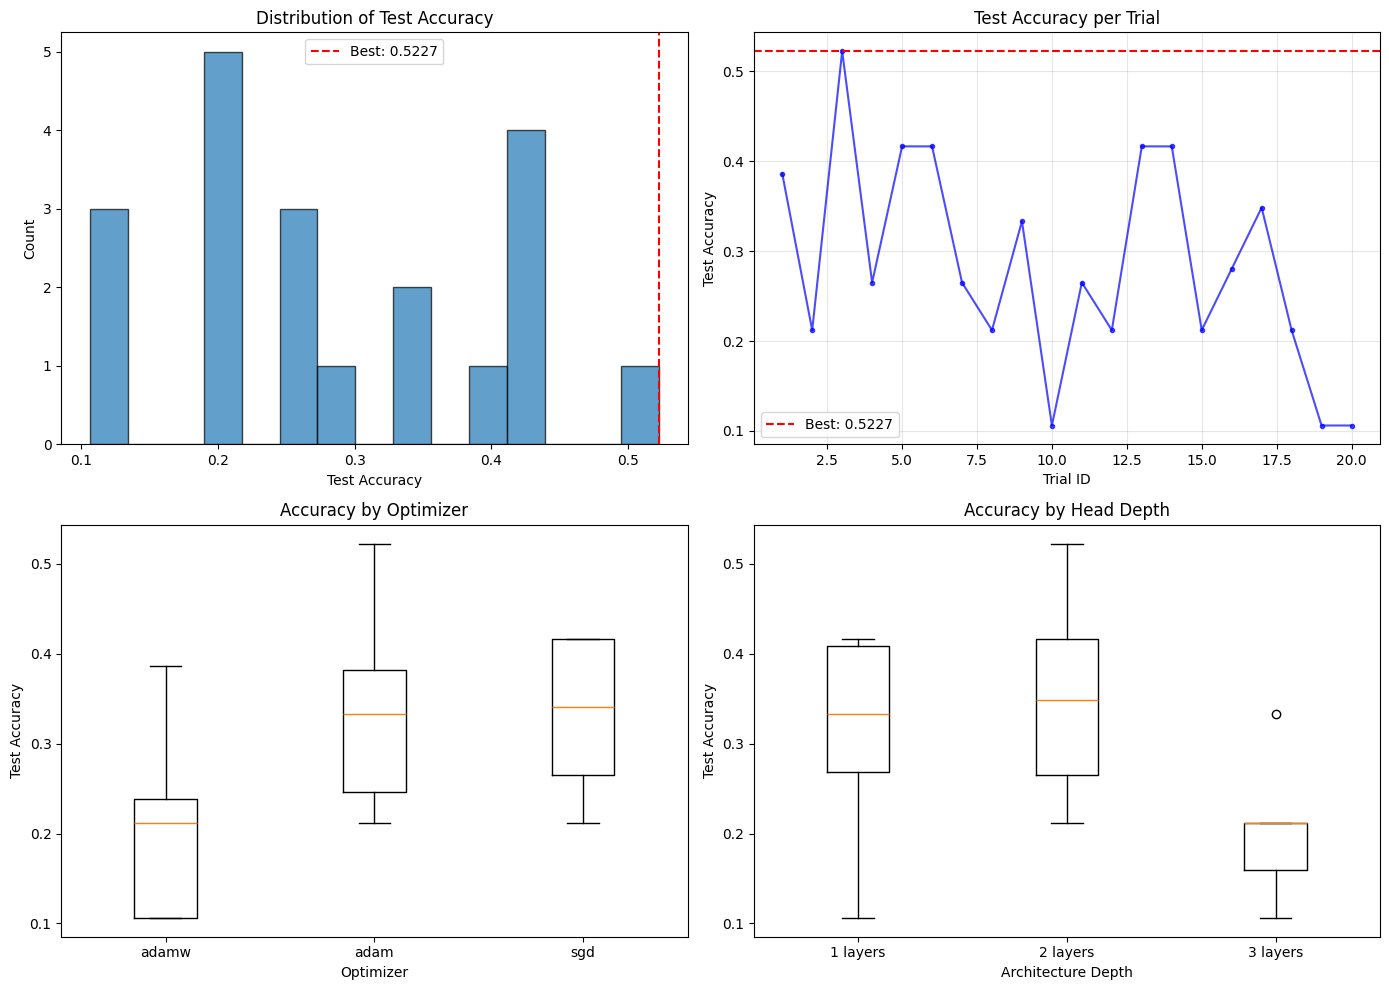


📊 Analysis plot saved to: random_search_results_resnet18\search_analysis_resnet18.png


In [30]:
# OPTIONAL: VISUALIZE RESULTS
import matplotlib.pyplot as plt

if len(all_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Accuracy distribution
    accuracies = [r['test_accuracy'] for r in all_results]
    axes[0, 0].hist(accuracies, bins=15, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(best_accuracy, color='red', linestyle='--', label=f'Best: {best_accuracy:.4f}')
    axes[0, 0].set_xlabel('Test Accuracy')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Distribution of Test Accuracy')
    axes[0, 0].legend()
    
    # 2. Accuracy vs Trial
    trial_ids = [r['trial_id'] for r in all_results]
    axes[0, 1].plot(trial_ids, accuracies, 'b.-', alpha=0.7)
    axes[0, 1].axhline(best_accuracy, color='red', linestyle='--', label=f'Best: {best_accuracy:.4f}')
    axes[0, 1].set_xlabel('Trial ID')
    axes[0, 1].set_ylabel('Test Accuracy')
    axes[0, 1].set_title('Test Accuracy per Trial')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Accuracy by Optimizer
    optimizers = list(set([r['params']['optimizer'] for r in all_results]))
    opt_accs = {opt: [r['test_accuracy'] for r in all_results if r['params']['optimizer'] == opt] for opt in optimizers}
    axes[1, 0].boxplot([opt_accs[opt] for opt in optimizers], labels=optimizers)
    axes[1, 0].set_xlabel('Optimizer')
    axes[1, 0].set_ylabel('Test Accuracy')
    axes[1, 0].set_title('Accuracy by Optimizer')
    
    # 4. Accuracy by Architecture depth
    depths = [len(r['params']['layer_options']) for r in all_results]
    depth_accs = {d: [r['test_accuracy'] for r in all_results if len(r['params']['layer_options']) == d] 
                  for d in set(depths)}
    axes[1, 1].boxplot([depth_accs[d] for d in sorted(depth_accs.keys())], 
                       labels=[f"{d} layers" for d in sorted(depth_accs.keys())])
    axes[1, 1].set_xlabel('Architecture Depth')
    axes[1, 1].set_ylabel('Test Accuracy')
    axes[1, 1].set_title('Accuracy by Head Depth')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'search_analysis_resnet18.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Analysis plot saved to: {RESULTS_DIR / 'search_analysis_resnet18.png'}")

---

## 📝 Catatan

### Perbedaan dengan Random Search ResNet50:

| Aspek | ResNet50 | ResNet18 |
|-------|----------|----------|
| Pre-trained | ✅ ImageNet | ❌ From scratch |
| LR Range | [1e-5, 1e-3] | [1e-4, 1e-2] |
| Fine-tune Layer | [100, 170] | [20, 50] |
| Epochs | Lebih sedikit | Lebih banyak |
| Patience | 10 | 15 |

### Jika hasil kurang memuaskan:

1. Gunakan model dengan **pre-trained weights**:
   - EfficientNet-B0
   - MobileNetV2
   - DenseNet121

2. Coba **longer training**:
   - Tambah epochs
   - Kurangi LR decay

---